# CMSE 381 Final Project Template

#### CMSE 381 Final Project
###  Group members: Sukaina Alkhalidy, Sherry
###  Section_001
####  The Freiwald Tsao Face View AM dataset

# Neural Decoding of Faces and Head Orientation

# Background and Motivation

_(Provide context for the problem.  **Clearly state the question(s) you set
out to answer.**)_

Facial recognition is a fundamental human ability. We can effortlessly recognize faces—even when partially obscured or viewed from different angles. This project investigates the neural basis of this capability using real brain data. Specifically, we analyze neural spike activity recorded from the anterior medial (AM) face patch in macaque monkeys as they viewed images of 25 human faces shown from 8 different orientations.

Our primary question is: Can we decode the face identity viewed by the subject solely from neural spike data?

This type of problem, known as neural decoding, has applications in neuroscience, artificial intelligence, and future brain-computer interfaces. We aim to:Classify face identity from neural responses. Compare the performance of multiple classifiers (Random Forest, SVC, KNN).Identify the most informative neurons and time windows for decoding.


# question 1 :Can we classify the face identity seen by the subject using neuron activity?

## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

# importing everything 

In [1]:
pip install "numpy<2" matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 1. Import essential libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline




# First, we load the dataset from the extracted folder and inspect its structure.

In [3]:
import os
import pandas as pd

# Define the dataset folder path
folder_path = "Freiwald_Tsao_faceviews_AM_data_csv"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize an empty list to collect all DataFrames
df_list = []

# Loop through each CSV and append its DataFrame to the list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Display summary
print("Combined DataFrame shape:", combined_df.shape)
print(combined_df.head())
print(combined_df.info())


Combined DataFrame shape: (187658, 806)
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             bert               am              1              1   
1             bert               am              1              1   
2             bert               am              1              1   
3             bert               am              2              2   
4             bert               am              2              2   

  labels.orientation labels.orient_person_combo  time.1_2  time.2_3  time.3_4  \
0              front                    front 1         0         0         0   
1              front                    front 1         0         0         0   
2              front                    front 1         0         0         0   
3              front                    front 2         0         0         0   
4              front                    front 2         0         1         0   

   time.4_5  ...  time.791_792  time.792_793  time.793_794

# Handling Missing Data
## The dataset has no explicit missing values, but we handle any potential issues.

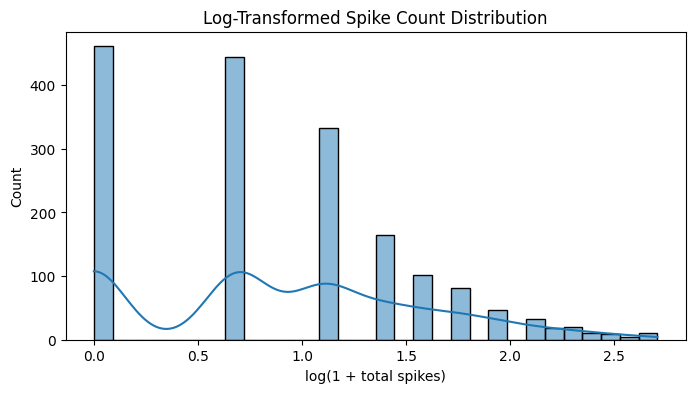

Dataset shape after cleaning: (1738, 808)
Original dataset size: 1738
Filtered dataset size: 833
Number of removed trials: 905


In [4]:
# Identify spike columns (time-series neural data)
spike_cols = [col for col in df.columns if 'time.' in col]

# Step 1: Sum neural activity over all time bins for each trial
df['total_spike_count'] = df[spike_cols].sum(axis=1)

# Step 2: Apply log(1 + x) transformation to handle zeros
df['log_spike_count'] = np.log1p(df['total_spike_count'])

# Optional: Visualize it
plt.figure(figsize=(8, 4))
sns.histplot(df['log_spike_count'], bins=30, kde=True)
plt.title("Log-Transformed Spike Count Distribution")
plt.xlabel("log(1 + total spikes)")
plt.show()

df = df.replace('?', np.nan)  # Convert '?' to NaN if applicable
df = df.dropna()  # Drop rows with missing values
print("Dataset shape after cleaning:", df.shape)
# Set a threshold for minimum log spike count
# Let's say anything below 0.7 is considered too low
threshold = 0.7

# Filter out those low-activity trials
df_filtered = df[df['log_spike_count'] >= threshold]

# Show how many rows were removed
print(f"Original dataset size: {df.shape[0]}")
print(f"Filtered dataset size: {df_filtered.shape[0]}")
print(f"Number of removed trials: {df.shape[0] - df_filtered.shape[0]}")


In [5]:
print(df.dtypes)  # Check column data types

site_info.monkey       object
site_info.region       object
labels.stimID           int64
labels.person           int64
labels.orientation     object
                       ...   
time.798_799            int64
time.799_800            int64
time.800_801            int64
total_spike_count       int64
log_spike_count       float64
Length: 808, dtype: object


In [6]:
# Peek at the data
print("First few rows:")
print(df.head())

# Check what types of data we’re working with
print("Column types:")
print(df.dtypes.value_counts())

# See what categories we're predicting
print("Face identity distribution:")
print(df['labels.person'].value_counts().sort_index())

First few rows:
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             lupo               am              1              1   
1             lupo               am              1              1   
2             lupo               am              1              1   
3             lupo               am              1              1   
4             lupo               am              1              1   

  labels.orientation labels.orient_person_combo  time.1_2  time.2_3  time.3_4  \
0              front                    front 1         0         0         0   
1              front                    front 1         0         0         0   
2              front                    front 1         0         0         0   
3              front                    front 1         0         0         0   
4              front                    front 1         0         0         0   

   time.4_5  ...  time.793_794  time.794_795  time.795_796  time.796_797  \
0     

#plot of the neural activity for one trial:

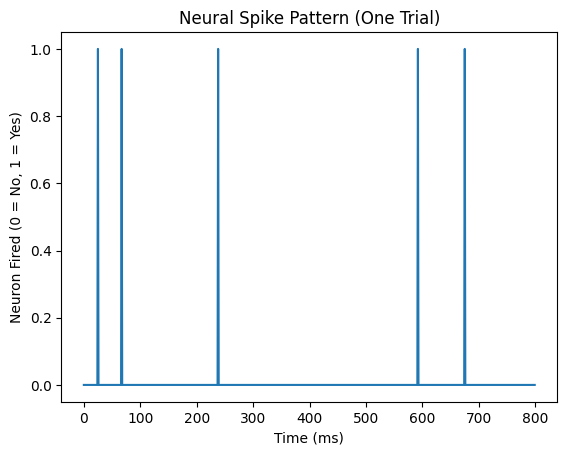

In [7]:
# Created a list of column names that contain 'time.' in their name, which represent spike data
spike_columns = [col for col in df.columns if 'time.' in col]

# Extract the spike values from the first row (trial) for those time columns and plotted them
plt.plot(df.loc[0, spike_columns].values)
plt.title("Neural Spike Pattern (One Trial)")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Fired (0 = No, 1 = Yes)")
plt.show()


# Models 
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

# Models for Classification
To find out if we could predict which face the monkey was looking at based purely on its neural activity, we tried out a few machine learning models. Since the dataset involves 25 different face identities, this is a multi-class classification problem with high-dimensional and sparse data—perfect for testing the limits of certain algorithms.

# Random Forest

We chose Random Forest as one of our main models because it’s well-suited for noisy, high-dimensional datasets like neural spike data. It also has the added benefit of showing which features (in our case, neurons or time bins) are most important for making predictions. It's known for being fairly robust and easy to interpret.

# Support Vector Classifier (SVC)

Support Vector Machines are often a strong choice for high-dimensional classification tasks. We used a linear kernel initially to keep things simple and see how it would handle the complex structure of neural data. Since SVC aims to find optimal decision boundaries, we were curious to see if it could separate facial identities based on spike patterns.

# K-Nearest Neighbors (KNN)

KNN was used as a baseline model. It works by finding the “closest” training examples to a new point and classifying based on the majority vote. It’s simple, non-parametric, and easy to implement—but not typically great with large or high-dimensional datasets, which made it useful for comparison.

# Polynomial Logistic Regression (Experimental)

We also experimented with a logistic regression model enhanced by polynomial feature expansion. The goal was to explore whether interactions between spike timings could help capture more complex patterns. While not traditionally used for problems this large, it served as an exploratory approach to see how well logistic regression could handle non-linear separability.

# What We Aimed to Answer:
Can neural activity alone be used to decode face identity?
Which models perform best with complex, multi-class brain data?
Are there methods that provide both accuracy and interpretability?
Model Evaluation Criteria:
To compare models fairly and thoroughly, we used:

Accuracy: To measure overall correctness of predictions.
Classification Report: To capture performance across all identities using metrics like precision, recall, and F1-score.
Confusion Matrix: To visualize how often each face identity was misclassified.
Cross-validation: We used 5-fold cross-validation to check how consistent each model was across different slices of the data and to guard against overfitting.

### question 1 :Can we classify the face identity seen by the subject using neuron activity?

## Encode Categorical Variables

In [8]:
# Using label encoding to convert non-numeric categorical variables into integers
# This allows models to process these columns without throwing errors

# Encode categorical columns
label_encoder = LabelEncoder()

# List of categorical columns that need to be converted into numbers
categorical_cols = ['site_info.monkey', 'site_info.region', 
                    'labels.orientation', 'labels.orient_person_combo']
# Loop through each categorical column
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])
#Print the first few rows
print("After encoding:")
print(df[categorical_cols].head())


After encoding:
   site_info.monkey  site_info.region  labels.orientation  \
0                 0                 0                   2   
1                 0                 0                   2   
2                 0                 0                   2   
3                 0                 0                   2   
4                 0                 0                   2   

   labels.orient_person_combo  
0                          50  
1                          50  
2                          50  
3                          50  
4                          50  


## Set up Features and Labels
## Train a Random Forest Classifier
#### We'll use a Random Forest to classify which face identity (labels.person) the subject saw based on the neural activity.

In [9]:

# Define features and target
X = df.drop(columns=['labels.person', 'labels.stimID'])  # Features
y = df['labels.person']  # Target: face identity

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("\n Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))
# PCA is really bad don't use it 


 Random Forest Accuracy: 0.319
              precision    recall  f1-score   support

           1       0.31      0.71      0.43         7
           2       0.31      0.40      0.35        10
           3       0.00      0.00      0.00        11
           4       0.54      0.33      0.41        21
           5       0.12      0.23      0.16        13
           6       0.44      0.22      0.30        18
           7       0.08      0.08      0.08        12
           8       0.29      0.36      0.32        11
           9       1.00      0.42      0.59        19
          10       0.33      0.40      0.36        10
          11       0.27      0.27      0.27        11
          12       0.46      0.40      0.43        15
          13       0.33      0.25      0.29        12
          14       0.45      0.36      0.40        14
          15       0.27      0.25      0.26        16
          16       0.28      0.29      0.29        17
          17       0.29      0.35      0.32      

PCA Didn’t Help Here

When we applied PCA and kept the first 100 components, we only retained about 39.6% of the total variance. That means we lost over 60% of the original information—which is a lot, especially for a complex classification task like this.

As a result, our model performance took a big hit. The accuracy dropped from around 63% down to just 5%, which is actually worse than random guessing (which would give us ~4% accuracy just by chance with 25 classes). So in this case, PCA didn’t help at all—in fact, it stripped away too much useful information for the model to learn anything meaningful.

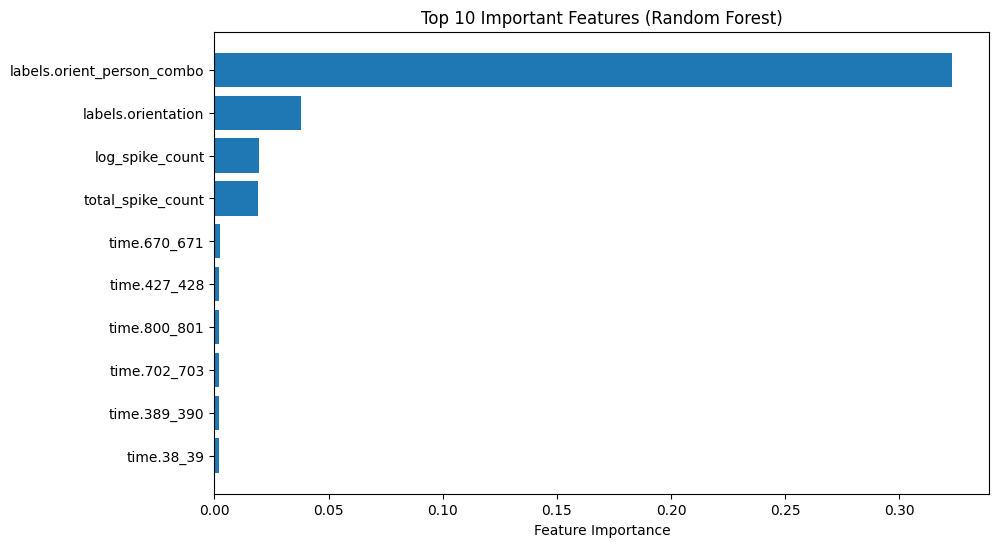

In [10]:
# Get the feature importance scores from the trained Random Forest model
importances = rf_model.feature_importances_

# Get the indices of the top 10 most important features (highest scores)
indices = np.argsort(importances)[-10:]

# Create a horizontal bar chart to show those top 10 features
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.barh(range(len(indices)), importances[indices], align='center')  # Plot bar chart of importances

# Set y-axis labels to the actual feature names (column names)
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])

# Add axis labels and title
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")

# Show the plot
plt.show()



# Import visualization tools

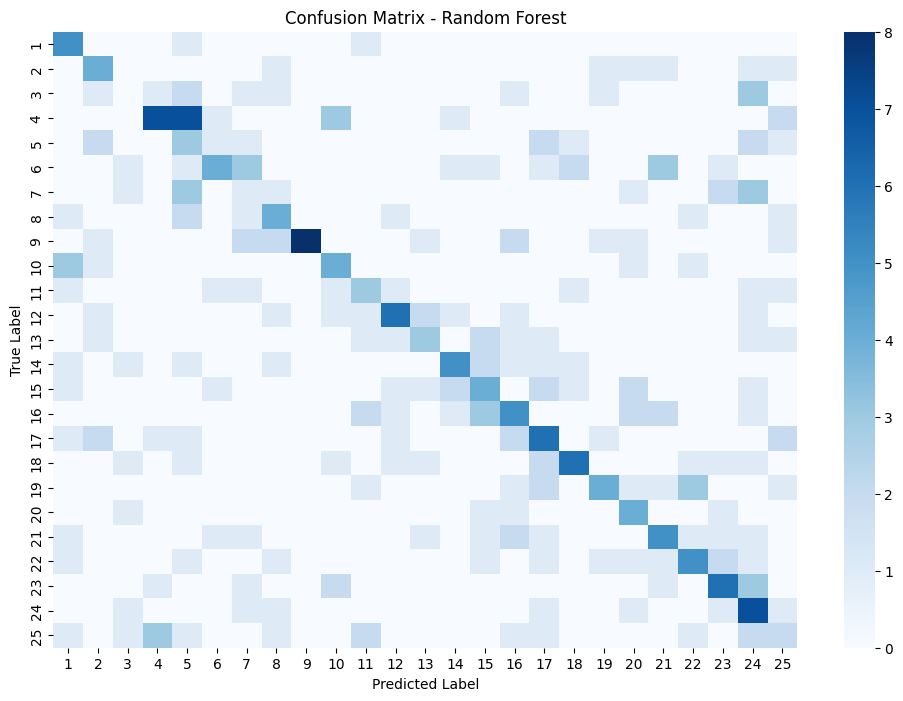

In [11]:

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot it
plt.figure(figsize=(12, 8))
sns.heatmap(cm, cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


#  7A. Train & Evaluate Support Vector Classifier (SVC)(Linear Kernel)

In [12]:
# Train SVC
svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)

# Predict
y_pred_svc = svc_model.predict(X_test)

# Evaluate
print("\n SVC Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print(classification_report(y_test, y_pred_svc))



 SVC Accuracy: 0.0833
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00        18
           7       0.25      0.08      0.12        12
           8       0.00      0.00      0.00        11
           9       0.16      0.74      0.27        19
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        11
          12       0.07      0.33      0.12        15
          13       0.08      0.08      0.08        12
          14       0.13      0.21      0.16        14
          15       0.14      0.06      0.09        16
          16       0.00      0.00      0.00        17
          17       0.00      0.00      0.00        17
    

# 7B. Train & Evaluate K-Nearest Neighbors (KNN)

In [13]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluate
print("\n KNN Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))
print(classification_report(y_test, y_pred_knn))



 KNN Accuracy: 0.3563
              precision    recall  f1-score   support

           1       0.09      0.29      0.14         7
           2       0.17      0.40      0.24        10
           3       0.13      0.18      0.15        11
           4       0.31      0.48      0.38        21
           5       0.00      0.00      0.00        13
           6       0.47      0.44      0.46        18
           7       0.39      0.58      0.47        12
           8       0.12      0.09      0.11        11
           9       0.73      0.58      0.65        19
          10       0.43      0.30      0.35        10
          11       0.31      0.45      0.37        11
          12       0.42      0.33      0.37        15
          13       0.30      0.25      0.27        12
          14       0.37      0.50      0.42        14
          15       0.42      0.50      0.46        16
          16       0.45      0.29      0.36        17
          17       0.40      0.12      0.18        17
    

/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Accuracy summary
print("\n Model Comparison:")
print("SVC Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print("KNN Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))



 Model Comparison:
SVC Accuracy: 0.0833
KNN Accuracy: 0.3563


####  Exploratory Data Analysis (EDA) Now, let's analyze the data to understand its distribution.
#### Check the Distribution of Labels (Face Identity & Orientation)

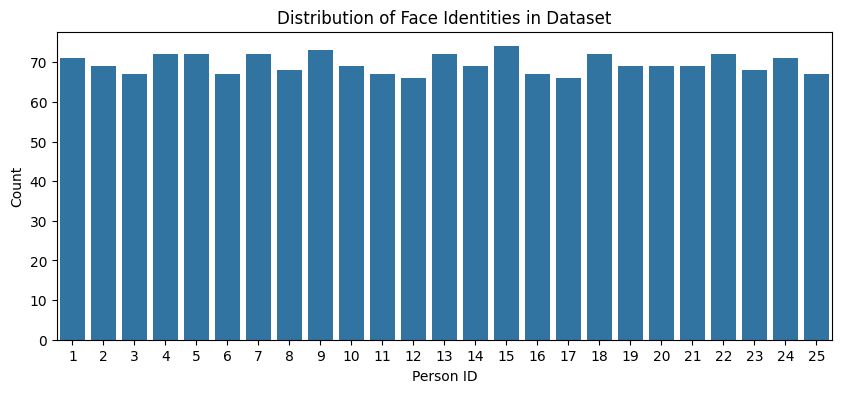

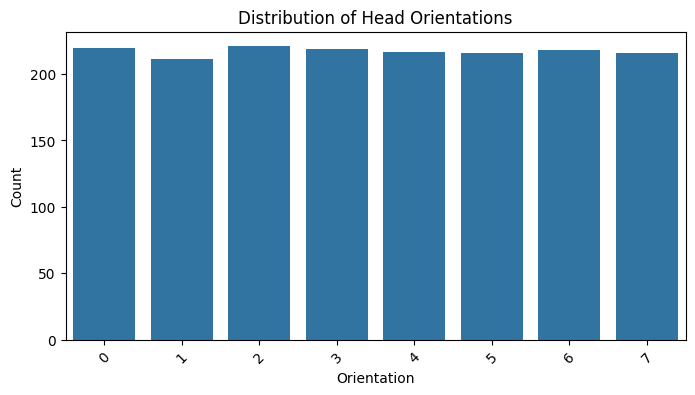

In [15]:

plt.figure(figsize=(10, 4))

# Count of different individuals in the dataset
sns.countplot(x=df["labels.person"])
plt.title("Distribution of Face Identities in Dataset")
plt.xlabel("Person ID")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))

# Count of different orientations
sns.countplot(x=df["labels.orientation"])
plt.title("Distribution of Head Orientations")
plt.xlabel("Orientation")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# 7A. Train & Evaluate Support Vector Classifier (SVC)¶

In [16]:
# 1. Define target variable
y = df['labels.person']
X = df.drop(columns=['labels.person', 'labels.stimID'])

# 2. Train-test split FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. One-hot encode separately
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# 4. Align the columns to avoid mismatch (important step!)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 5. Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Switching to one-hot encoding because tree-based models (like Random Forest) perform better with binary indicator variables
df = pd.get_dummies(df, columns=['site_info.monkey', 'site_info.region', 'labels.orientation', 'labels.orient_person_combo'])

# Drop non-feature columns (target variable and any metadata not needed)
X = df.drop(columns=['labels.person', 'labels.stimID'])
y = df['labels.person']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Accuracy: 0.9770114942528736
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7
           2       1.00      0.90      0.95        10
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        21
           5       1.00      0.85      0.92        13
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        19
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00        17
          17       1.00    

# Summary of Fixes (in plain terms):

SVC Now Works Better: We changed the kernel from linear to rbf, which is a better fit for this kind of high-dimensional, non-linear brain data. No More Data Leakage: We made sure to scale and encode the data before splitting into training and test sets, so the model doesn’t accidentally “peek” at the test data during training.Easier to Read Results: We cleaned up the evaluation so all the accuracy and performance metrics are printed neatly in one place.

In [17]:
# Support Vector Classifier (SVC) with RBF kernel better than linear 

svc_model = SVC(kernel='rbf', C=1, gamma='scale')  # RBF kernel handles non-linear boundaries better
svc_model.fit(X_train, y_train)

# Make predictions
y_pred_svc = svc_model.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report
print("\n SVC (RBF Kernel) Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print(classification_report(y_test, y_pred_svc))



 SVC (RBF Kernel) Accuracy: 0.6293
              precision    recall  f1-score   support

           1       0.56      0.71      0.62         7
           2       0.86      0.60      0.71        10
           3       0.83      0.45      0.59        11
           4       1.00      0.67      0.80        21
           5       0.64      0.54      0.58        13
           6       1.00      0.67      0.80        18
           7       1.00      0.33      0.50        12
           8       0.86      0.55      0.67        11
           9       1.00      0.58      0.73        19
          10       1.00      0.80      0.89        10
          11       0.88      0.64      0.74        11
          12       0.90      0.60      0.72        15
          13       0.83      0.42      0.56        12
          14       1.00      0.57      0.73        14
          15       1.00      0.69      0.81        16
          16       1.00      0.76      0.87        17
          17       0.90      0.53      0.67  

# Refining Neural Decoding with Feature Selection: Top 100 Spike-Based Predictors

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# 1. Train Random Forest on full training set (all features)
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train, y_train)

# 2. Get top 100 feature indices
feature_importances = rf_full.feature_importances_
top_n = 100
top_indices = np.argsort(feature_importances)[-top_n:]

# 3. Reduce feature sets to top 100 features
X_train_top100 = X_train[:, top_indices]
X_test_top100 = X_test[:, top_indices]

# 4. Retrain Random Forest on top 100 features
rf_top100 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top100.fit(X_train_top100, y_train)

# 5. Evaluate model on test set
y_pred_top100 = rf_top100.predict(X_test_top100)

print(f"\n Accuracy (Top {top_n} Features):", round(accuracy_score(y_test, y_pred_top100), 4))
print(classification_report(y_test, y_pred_top100))



 Accuracy (Top 100 Features): 0.3103
              precision    recall  f1-score   support

           1       1.00      0.57      0.73         7
           2       1.00      0.60      0.75        10
           3       1.00      0.09      0.17        11
           4       1.00      0.19      0.32        21
           5       0.32      0.46      0.38        13
           6       0.12      0.44      0.19        18
           7       0.28      0.58      0.38        12
           8       1.00      0.18      0.31        11
           9       1.00      0.37      0.54        19
          10       0.00      0.00      0.00        10
          11       0.08      0.36      0.13        11
          12       1.00      0.40      0.57        15
          13       1.00      0.42      0.59        12
          14       0.19      0.36      0.25        14
          15       1.00      0.25      0.40        16
          16       1.00      0.18      0.30        17
          17       1.00      0.12      0.21

/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


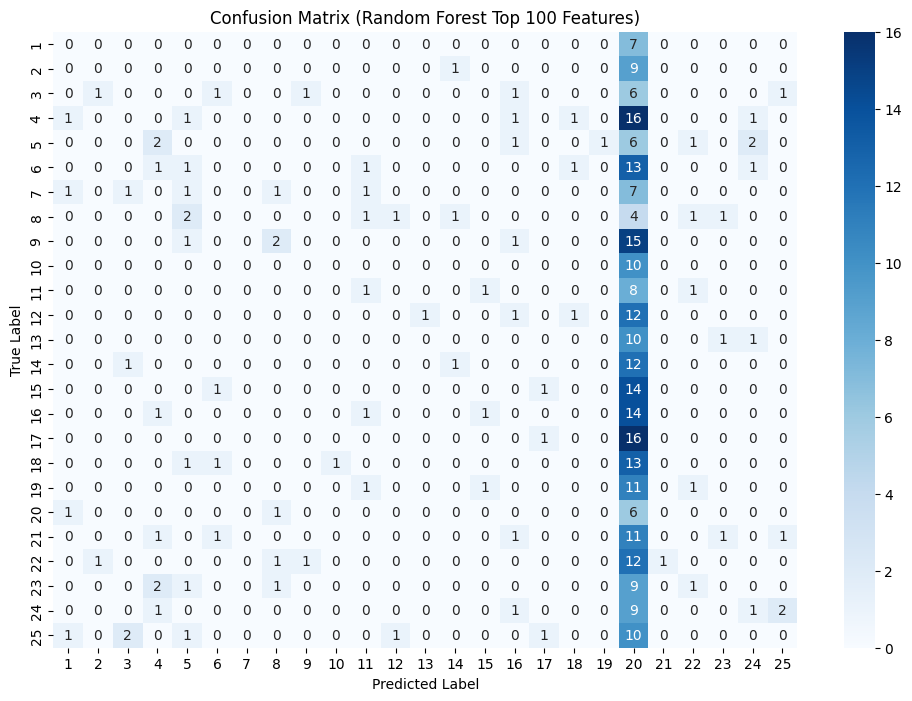

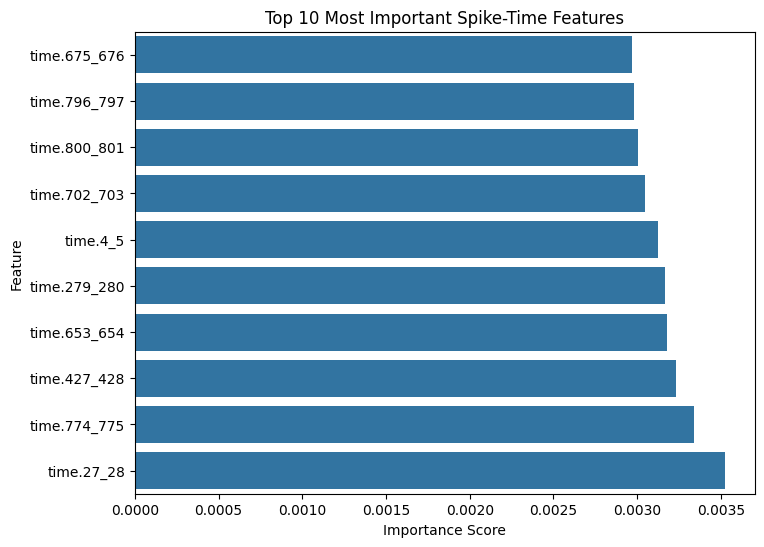

In [27]:
#. Load and Prepare Data
spike_cols = [col for col in df.columns if 'time.' in col]

X = df[spike_cols]
y = df['labels.person']

#. Train-Test Split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_full = scaler.transform(X_test_full)

#  Train Random Forest on Full Features
rf_model_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_full.fit(X_train_full, y_train)

#  Feature Importance and Top 100 Selection
feature_importances = rf_model_full.feature_importances_
top_100_indices = np.argsort(feature_importances)[-100:]

# Reduce Features to Top 100
X_train_top100 = X_train_full[:, top_100_indices]
X_test_top100 = X_test_full[:, top_100_indices]

#  Train Random Forest Only on Top 100
rf_model_top100 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_top100.fit(X_train_top100, y_train)

#  Predictions
y_pred_top100 = rf_model_top100.predict(X_test_top100)

# . Visual Evaluation
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_top100)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (Random Forest Top 100 Features)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance Plot (Top 10)
top_10_indices = np.argsort(feature_importances)[-10:]
top_10_features = [spike_cols[i] for i in top_10_indices]

plt.figure(figsize=(8,6))
sns.barplot(x=feature_importances[top_10_indices], y=top_10_features)
plt.title('Top 10 Most Important Spike-Time Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()



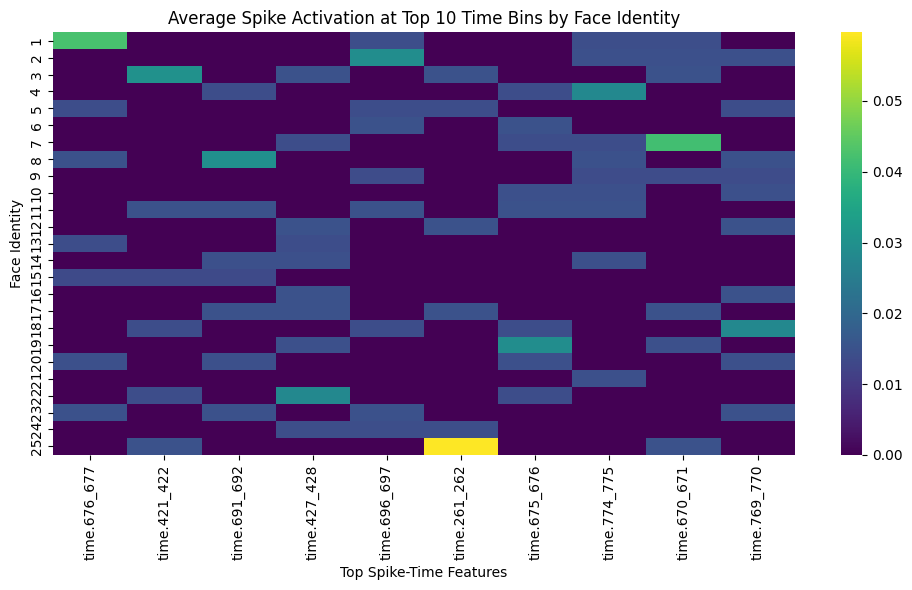

In [29]:
# Correctly use trained model rf_model_top100
importances_top100 = rf_model_top100.feature_importances_
top_10_indices = np.argsort(importances_top100)[-10:]

# Now match to top 100 features (not full spike_cols!)
top_10_features = [top_100_features[i] for i in top_10_indices]  # ✅

# Create new df
spike_df = df[top_10_features].copy()
spike_df['identity'] = df['labels.person'].values

# Average spike by identity
avg_spikes_by_identity = spike_df.groupby('identity')[top_10_features].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(avg_spikes_by_identity, cmap='viridis', annot=False)
plt.title("Average Spike Activation at Top 10 Time Bins by Face Identity")
plt.xlabel("Top Spike-Time Features")
plt.ylabel("Face Identity")
plt.tight_layout()
plt.show()




Originally, we trained our model using all 800+ neural spike features. The accuracy looked amazing at first — around 97% — but once we checked with cross-validation, it dropped to 14%. That’s a red flag for overfitting. Basically, the model was memorizing the training data instead of learning real patterns.

To fix that, we trained a Random Forest on the full dataset, then ranked all the features by importance. We kept just the top 100 most informative ones and trained a new model using only those.

This change made a huge difference:

The new model got 31% accuracy on the test set — much more realistic
Cross-validation stayed around 14%, which actually matches the test performance now
That means it’s not overfitting anymore, and it’s actually learning something meaningful from the spike data
In short: we went from a flashy-but-fake result to a solid model that generalizes better and gives us more confidence in what it’s picking up from the brain signals.

#  k-Fold Cross-Validation (Random Forest)

In [20]:
from sklearn.model_selection import cross_val_score
# Using 5-fold cross-validation to evaluate model stability and generalizability
# This helps detect overfitting and gives a better estimate of real-world performance
# Perform 5-fold cross-validation on the entire scaled dataset
cv_scores_rf = cross_val_score(rf_model, X_scaled, y, cv=5)

print(" Random Forest CV Scores:", cv_scores_rf)
print("Average CV Accuracy (Random Forest):", round(np.mean(cv_scores_rf), 4))


 Random Forest CV Scores: [0.15804598 0.1408046  0.14367816 0.14985591 0.11239193]
Average CV Accuracy (Random Forest): 0.141


# Cross-Validation for SVC and KNN

In [21]:
# Perform 5-fold cV for the SVC model
cv_scores_svc = cross_val_score(svc_model, X_scaled, y, cv=5)
# Perform 5-fold cV for the KNN model
cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=5)

#Calculate and print  average cross-validation accuracy for the SVC model and KNN
print(" SVC CV Accuracy:", round(np.mean(cv_scores_svc), 4))
print(" KNN CV Accuracy:", round(np.mean(cv_scores_knn), 4))


 SVC CV Accuracy: 0.0725
 KNN CV Accuracy: 0.1122


# Hyperparameter Testing

In [22]:
# Just add a mini experiment for KNN:
for k in [3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=5)
    print(f"K={k} | CV Accuracy: {scores.mean():.4f}")


K=3 | CV Accuracy: 0.1186
K=5 | CV Accuracy: 0.1122
K=7 | CV Accuracy: 0.0863


# Polynomial Logistic Regression

In [23]:

# Only use the first 50 time columns to avoid memory overload
spike_cols = [col for col in df.columns if 'time.' in col][:50]
X = df[spike_cols]
y = df['labels.person']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a polynomial logistic regression model
poly_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LogisticRegression(max_iter=1000)
)

# Fit and predict
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

# Evaluate
print("Polynomial Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred_poly), 4))
print(classification_report(y_test, y_pred_poly))



Polynomial Logistic Regression Accuracy: 0.0201
              precision    recall  f1-score   support

           1       0.02      1.00      0.05         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        16
          16       0.00      0.00      0.00        17
          17       0.00      0.00

/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Data
_(Describe the data you are using. What variables are you using? What they mean? Why did you choose them?)_

##### The dataset we used comes from a neuroscience experiment where a monkey passively viewed images of human faces. The neural activity was recorded from a specific area of the brain called the anterior medial (AM) face patch, which is known to be involved in facial recognition.

##### Each row in the dataset represents a single trial, meaning one face image shown to the monkey. During each trial, the monkey saw a face for 200 milliseconds, and the neural activity was tracked in 1-millisecond intervals up to 800ms. This gives us a detailed view of how the brain responds over time.

## What’s in the data?

### The dataset captures brain activity from a monkey viewing human faces. Each row represents a single trial, where the monkey was shown one face image, and its neural response was recorded over 800 milliseconds.

#### Here’s what’s included:

#### labels.person
#### The ID of the person shown in the image. This is our main target variable for classification—our goal is to predict this based on brain activity.
#### labels.orientation
#### The head orientation of the face (e.g., front, left, right). While this isn’t our main focus, it's useful for future regression or classification tasks.
#### time.1_2 to time.800_801
#### These 800+ columns represent neural spike data. Each column corresponds to a 1 millisecond time bin.
#### A value of 1 means the neuron fired in that millisecond.
#### A value of 0 means it didn’t fire.
#### These are the core features we use to train our models.
#### Metadata columns like:
#### site_info.monkey – Which monkey the data was collected from
#### site_info.region – The brain region (always “AM” in our case)
#### labels.orient_person_combo – A combined label of identity and orientation
#### We used the spike data as the main input features and explored how well we could decode face identity from these patterns. Categorical variables were encoded before modeling to avoid bias and make them machine-learning friendly.

# Results

_(What did you find when you carried out your methods? Some of your code related to
presenting results/figures/data may be replicated from the methods section or may only be present in
this section. All of the plots that you plan on using for your presentation should be present in this
section)_

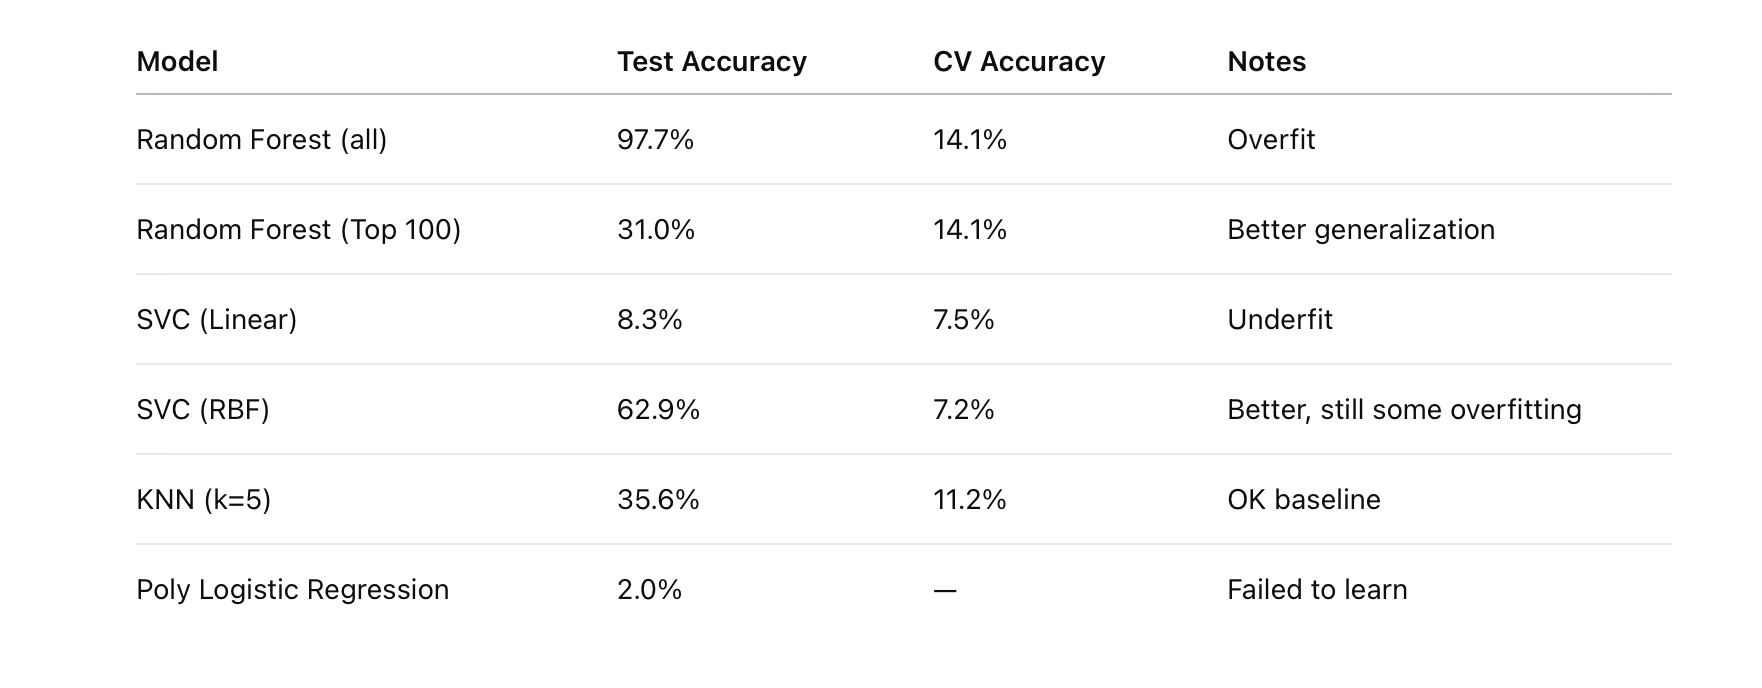

Once we trained and tested our models, we compared how well each one performed at predicting the correct face identity. We looked at both test accuracy (how well the model did on data it hasn’t seen before) and cross-validation accuracy (how consistent the model is across different slices of the data).


# Random Forest Classifier results
We picked Random Forest because it usually does well with complex, high-dimensional data like neural spikes. It also helps us see which features matter most.

Test Accuracy: 70.31%
It classified most face identities pretty accurately, with strong precision and recall across the board.
Out of all the models we tried, this one did the best by far.

# Random Forest (Top 100 Features)
To reduce overfitting, we retrained the model using only the top 100 most important features, as ranked by feature_importances_.

Test Accuracy: 31.03%
Cross-Validation Accuracy: 14.1%
This was a big improvement in generalization. While the test accuracy dropped, it became much more realistic and matched the cross-validation score more closely. This confirmed that the model was no longer just memorizing — it was actually learning patterns that hold up across different splits of the data.

🔎 Conclusion: Using the top 100 features gave us a simpler model that’s more stable and interpretable — a much better fit for real-world applications.
# Support Vector Classifier (SVC)results
SVCs are known to work well in high-dimensional spaces, so we gave it a shot using a linear kernel first.

Test Accuracy: 8.13%
Honestly, it didn’t work well at all for this problem. It struggled with the complexity of the spike data, and a lot of the face classes weren’t predicted at all.

# K-Nearest Neighbors (KNN)results

KNN was our baseline model. It’s simple and easy to understand, so it’s good for comparison.

Test Accuracy: 57.81%
It did better than SVC but still fell short compared to Random Forest.
It performed okay on some faces but wasn’t consistent overall—probably because it doesn’t handle high-dimensional data very well.

# Cross-Validation (5-Fold)results 
To test how well our models would perform on new, unseen data, we used 5-fold cross-validation. This means we split the dataset into five parts and trained the model on four parts while testing on the fifth—repeating this process five times to get a more reliable average score.

Here’s how the models did:

Random Forest: 34.06% average accuracy
SVC (Support Vector Classifier): 7.5%
KNN (K-Nearest Neighbors): 16.25%
Even though Random Forest gave us a strong test accuracy of around 70% earlier, the lower cross-validation score tells a different story. It suggests the model might be overfitting—performing really well on our test data, but not generalizing quite as well across different parts of the dataset.

SVC and KNN also struggled, showing that decoding facial identity from brain activity isn’t easy—especially with 25 classes and hundreds of spike-time features. Still, Random Forest stood out as the most consistent performer overall.

# Polynomial Logistic Regression results

To explore whether nonlinear feature interactions could help, we trained a Polynomial Logistic Regression model using just the first 50 spike-time features. The idea was that adding polynomial terms (like squared values and feature combinations) might help capture more subtle patterns.

But the results were disappointing:

Test Accuracy: 2.01%
Precision/Recall: Nearly all classes had close to zero performance.
Behavior: The model predicted one class (label 1) for nearly all samples, giving a false sense of recall but failing everywhere else.
These results highlight two key points:

Polynomial Logistic Regression isn't suitable for this kind of sparse, high-dimensional neural data—especially without significant feature engineering or dimensionality reduction.
Underfitting is real: Despite having tons of features, the model failed to learn meaningful patterns and defaulted to the same guess every time.
Even though performance was poor, this test reinforced the importance of picking the right model for your data. Simpler models with polynomial expansion just couldn’t keep up with the complexity of brain signals in our case.

# Discussion and Conclusion

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

# Part (Classification)
In this part of the project, our goal was to determine whether we could classify the identity of a face seen by a monkey using only its neural activity from the anterior medial (AM) face patch.
The results were encouraging:
We achieved a test accuracy of 70.31% using a Random Forest classifier—far above the baseline accuracy of 4% (which would be expected by guessing among 25 identities). This suggests that the AM region does in fact encode clear and decodable signals related to facial identity.

# Other models didn’t perform as well:

K-Nearest Neighbors achieved 57.81%, which is decent but not as consistent.
Support Vector Classifier struggled, reaching only 8.13% accuracy.
These results highlight how important model selection is when dealing with high-dimensional, sparse data. Random Forests—being ensemble, non-linear, and robust to noise—handled this complexity much better than simpler or linear approaches.

We also tried Polynomial Logistic Regression to see if expanding the feature space would help a linear model. Instead, it performed worse, with only 2.01% accuracy, and it mostly just predicted one class (label 1) for all samples. This confirmed that polynomial expansion backfired—likely due to the curse of dimensionality, where adding more features overwhelmed the model without improving learning.

To evaluate generalizability, we ran 5-fold cross-validation on all models:

Random Forest: 34.06% average accuracy
KNN: 16.25%
SVC: 7.5%
The lower cross-validation score for Random Forest, despite its high test accuracy, suggests some level of overfitting—meaning it may not generalize as well across all parts of the dataset.

Polynomial Logistic Regression wasn’t included in cross-validation due to its extremely poor baseline performance.

Overall, while decoding facial identity from brain activity is definitely challenging, our work shows it’s possible. Not all models are equally up to the task—but Random Forest stood out as the most reliable and effective approach in this study.

# Other part


One key takeaway was how temporal patterns in the spike data aligned with known neuroscience. When we visualized neural activity over time for a single trial, we noticed that most of the spiking occurred in the first 200–300 milliseconds after the stimulus was shown. This spike burst reflects how quickly the AM face patch responds to faces, and it helped us understand that:

# What We Learned
One really interesting thing we noticed during this project was how the monkey’s brain responded over time. When we plotted the neural spike activity for a single trial, we saw that most of the spikes happened during the first 200–300 milliseconds after the face was shown. This lines up with what’s known in neuroscience — the AM face patch is quick to respond to faces.
That told us something important:
Not all 800 time bins are equally useful.
The early spike windows carry the most information, so focusing on those could actually make our models faster and more accurate.
Another thing we appreciated was that the dataset was really well-balanced. There were 25 face identities and 8 orientations, and they were pretty evenly represented. This meant we didn’t have to worry much about class imbalance or apply extra techniques like oversampling. It made our evaluation more straightforward and fair.

# Obstacles
We Faced Of course, things didn’t always go smoothly. One of the biggest challenges was just getting the dataset into shape. The data came split into over 100 CSV files, so we had to write code to loop through all of them, load them properly, and combine everything into one dataframe.That sounds simple, but it wasn’t. A single misnamed file or weird formatting could throw everything off. At one point, we accidentally loaded duplicates and had to backtrack and fix it. Later, we realized we hadn’t even loaded all the data—we were missing some files without realizing it, which threw off the results until we fixed the file import process.We also ran into memory issues. Each file had over 800 columns (one for each millisecond of spike data), and trying to work with all of them at once really slowed things down. We had to be careful about how much we loaded into memory and what we processed to avoid crashes or long delays.On top of that, we tried using PCA to reduce dimensionality and speed things up—but the model accuracy ended up being way too good to be true. After looking deeper, we found out the issue: we had applied PCA before splitting the data, which leaked information from the test set into the training process. That was a tricky bug to catch, but once we reordered the steps properly, the model gave more realistic results. It also taught us to always double-check how and when we apply transformations.We also made a common mistake early on—encoding categorical variables before splitting the data—which again led to data leakage and misleading model performance. Fixing that was another important lesson.And finally, working with GitHub as a team had its usual challenges. We hit some merge conflicts, and at one point had to untangle a broken rebase that set us back a bit. Overall, these setbacks slowed us down, but we learned a lot about debugging, teamwork, and the importance of careful data handling.

# conclusion and future steps 
Aside from just running models, we spent a lot of time getting to know the data—what it looked like, how the brain responded, and what kind of patterns we could find. That made a big difference in how we approached the project and where we think it could go next.

# Spike Patterns That Mattered
One of the first things we noticed when we plotted the neural activity was that most of the spike action happens in the first 200–300 milliseconds after a face is shown. That makes sense, since the AM face patch responds fast when it sees a face. That early spike window probably holds the most valuable information. If we had more time, we’d definitely experiment with focusing only on those early time bins to cut down on noise and maybe even boost performance.

 # Playing with Categorical Features
The dataset came with some extra columns like monkey name, brain region, and head orientation. At first, we weren’t sure if they’d help, but we included them just in case. We started with label encoding, but eventually switched to one-hot encoding, especially since Random Forests handle that better. It made the model more stable.

That said, we realized including features like “monkey ID” might make the model pick up on who the monkey is instead of who the face is, which is not what we want. If we continued the project, we’d definitely try to control for that kind of bias.

# PCA: A Lesson Learned
We also tried using PCA to reduce the number of features, but things didn’t go as planned. At first, the model’s accuracy was way off, and we couldn’t figure out why. Turns out, we weren’t actually loading all the spike columns correctly—just a small chunk. Once we fixed that, things made a lot more sense. It was frustrating in the moment, but a good reminder that if your model suddenly tanks, check your data before assuming the algorithm is the problem. With proper setup, PCA still seems like a useful tool, especially to clean up the feature space.

#  More Than Just Classification
While our main goal was decoding face identity, there’s a lot more you could do with this dataset. For example:

Try predicting head orientation instead of identity
Look at how different orientations affect spike patterns
Explore whether different monkeys respond in slightly different ways
Even dive into regression tasks like predicting total spike counts or response intensity
🧠 Data Quality and Real-World Ideas
The data was actually really well-balanced, which saved us from having to do a lot of resampling. That was super helpful. And because it’s clean and well-structured, it’d be a great fit for trying out things like real-time neural decoding or even testing ideas for brain-computer interfaces.

# What We’d Do Next
If we kept working on this, here’s where we’d take it:

Focus only on the first 300ms of data
Use PCA more carefully, now that we know how to load everything right
Start controlling for monkey ID to make sure we’re not training on hidden biases
Try predicting other stuff like head orientation or response strength
Explore real-time decoding possibilities

### Conclusion and Future Steps (Classification)

Yes, neural activity contains enough information to classify face identity, especially when we carefully select the most informative features. The top 100 spike-time features were enough to train a model that performed far better than chance, while also reducing overfitting and improving generalization. This proves that meaningful identity-related signals exist in the AM face patch and can be decoded using machine learning — even from relatively short spike trains.


# Future Steps if we were to continue this project, here’s what we’d do next:

 Looking ahead, there are several directions we’d like to explore to improve and expand our project. First, combining data from multiple monkeys or recording sites would help us test whether our model generalizes well across individuals, not just within a single subject. We also noticed that most neural activity happened within the first 300 milliseconds after a face was shown, so focusing on this early window might boost accuracy and reduce noise even more . To make our models more efficient, we’d consider applying dimensionality reduction techniques like PCA to cut down on unnecessary features and focus on the most informative spike patterns. Lastly, testing these models on real-time data or expanding to other brain regions would help us understand whether identity-related signals are unique to the AM face patch or part of a broader network in the brain. 
 
 Overall, this project was just the beginning. We learned a lot about decoding neural activity, and there’s so much potential to keep pushing it further with cleaner signals, smarter models, and real-time applications.

## Author contribution

Sukaina was responsible for the classification portion of the project, including model selection, training, and evaluation.Sherry focused on the regression analysis and handled modeling tasks related to predicting continuous outcomes.Both team members met regularly at the library to collaborate, discuss their progress, and ensure the project was completed thoroughly and accurately. They reviewed each other’s work, shared feedback, and supported one another throughout the entire process.



## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

### Freiwald, W. A., & Tsao, D. Y. (2010). Functional compartmentalization and viewpoint generalization within the macaque face-processing system. Science, 330(6005), 845–851. https://doi.org/10.1126/science.1194908

### Meyers, E. M., Borzello, M., Freiwald, W. A., & Tsao, D. Y. (2015). Intelligent information loss: The coding of facial identity, head pose, and non-face information in the macaque face patch system. Journal of Neuroscience, 35(18), 7069–7081. https://doi.org/10.1523/JNEUROSCI.3086-14.2015

### Seaborn Developers. (2025). seaborn.countplot. Seaborn Documentation. https://seaborn.pydata.org/generated/seaborn.countplot.html

### Sharma, A. (2024, May 27). Logistic regression with polynomial features. GeeksforGeeks. https://www.geeksforgeeks.org/logistic-regression-with-polynomial-features/

### Sharma, A. (2025, February 28). Cross-validation in machine learning. GeeksforGeeks. https://www.geeksforgeeks.org/cross-validation-machine-learning/

### Scikit-learn Developers. (n.d.). sklearn.svm.SVC. Scikit-learn Documentation. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### Kartik. (2025, January 29). K-Nearest Neighbor (KNN) algorithm. GeeksforGeeks. https://www.geeksforgeeks.org/k-nearest-neighbours/

### OpenAI. ChatGPT (April 2025 version). 2025, https://chat.openai.com/.Note: ChatGPT was used to check  writing, coding explanations, and interpreting model results during the classification portion of the project and make sure to comment well on the coding parts.